In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from copy import deepcopy
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.vocs import VOCS

vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)


<Axes: >

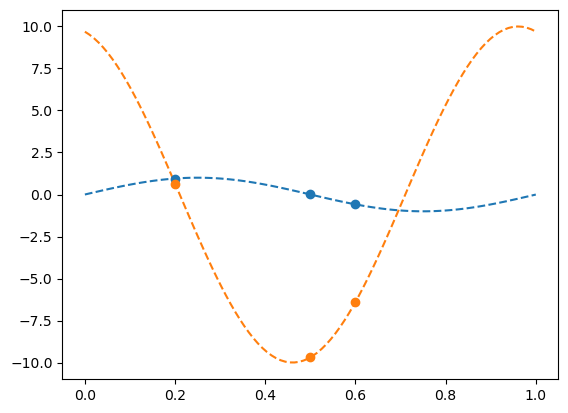

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return 10.0*torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Normal Model with Standard transforms and no constraints
- acquisition function is UCB with beta = 2

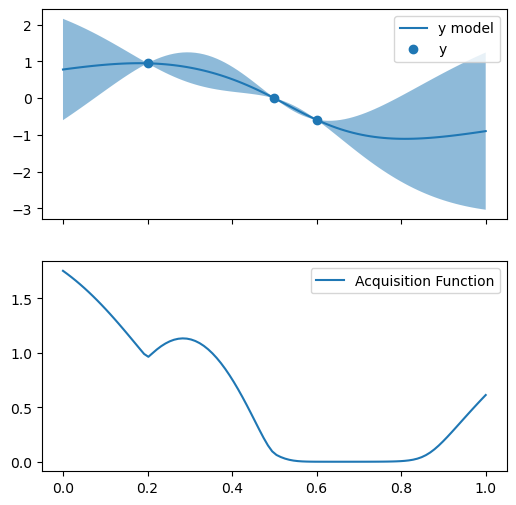

In [3]:
from xopt.utils import visualize_model

# plot the generator model and acquisition function
generator = UpperConfidenceBoundGenerator(deepcopy(vocs), UpperConfidenceBoundGenerator.default_options())
generator.vocs.constraints = {}

visualize_model(generator, data)

# Normal Model with Standard transforms and constraints

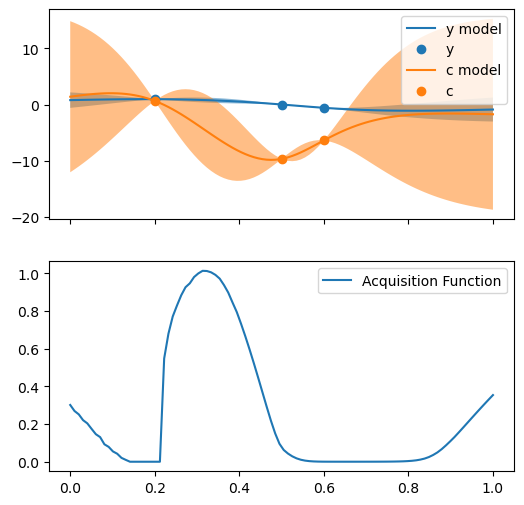

In [4]:
# plot the generator model and acquisition function
generator = UpperConfidenceBoundGenerator(deepcopy(vocs), UpperConfidenceBoundGenerator.default_options())
generator.vocs.constraints = {"c": ["LESS_THAN", 0]}

visualize_model(generator, data)


# Normal Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be biased away from the sides due to the prior
mean (note that the lengthscale is long so its not heavily biased)

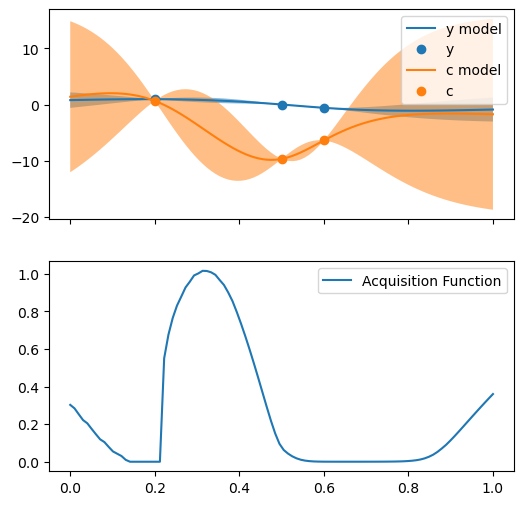

In [5]:
# plot the generator model and acquisition function
generator = UpperConfidenceBoundGenerator(deepcopy(vocs), UpperConfidenceBoundGenerator.default_options())

visualize_model(generator, data)


# Conservative Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be heavily biased away from the sides due to the prior
mean and short prior lengthscale
- make sure to use a strong prior on the noise to reduce it

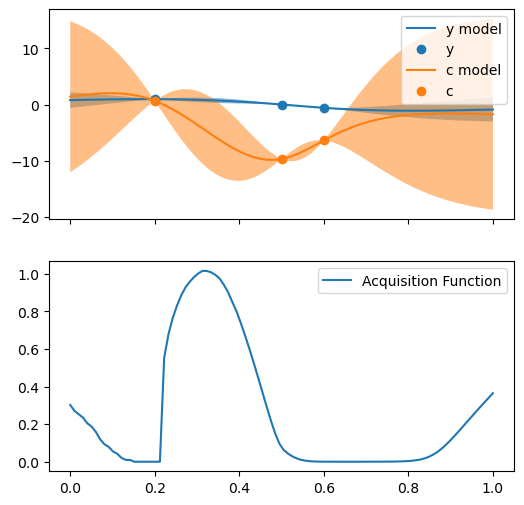

In [6]:
# plot the generator model and acquisition function
generator = UpperConfidenceBoundGenerator(deepcopy(vocs), UpperConfidenceBoundGenerator.default_options())

visualize_model(generator, data)


# Normal model with standard transforms and proximal biasing

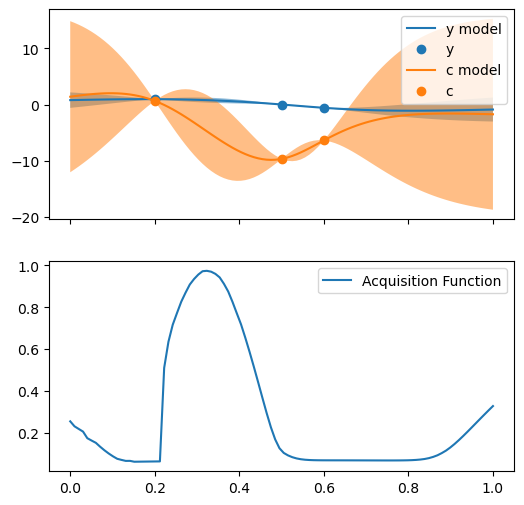

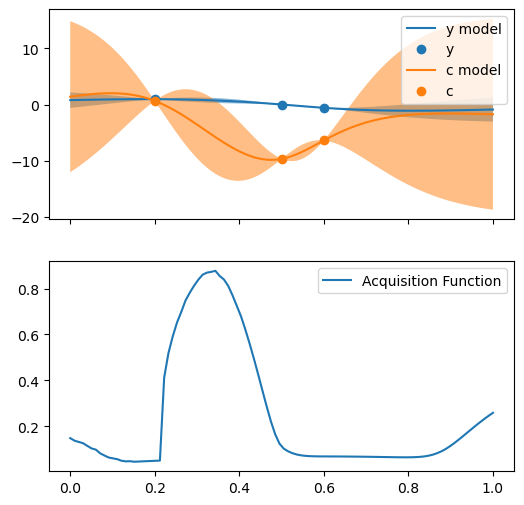

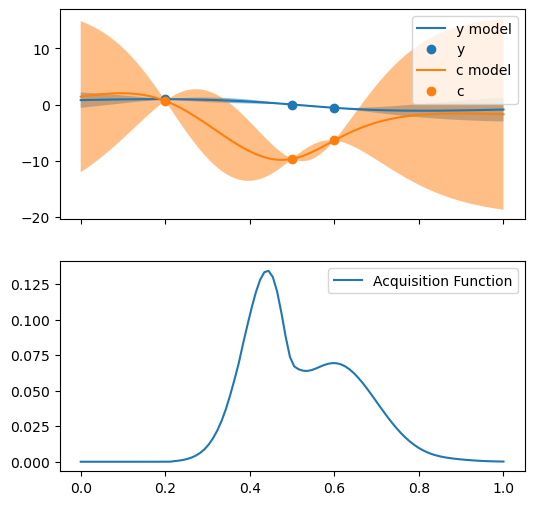

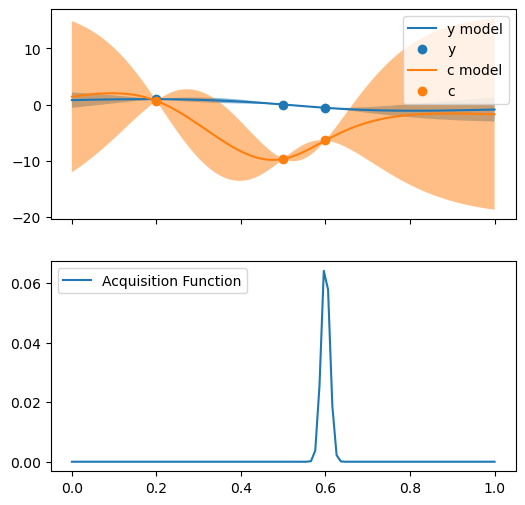

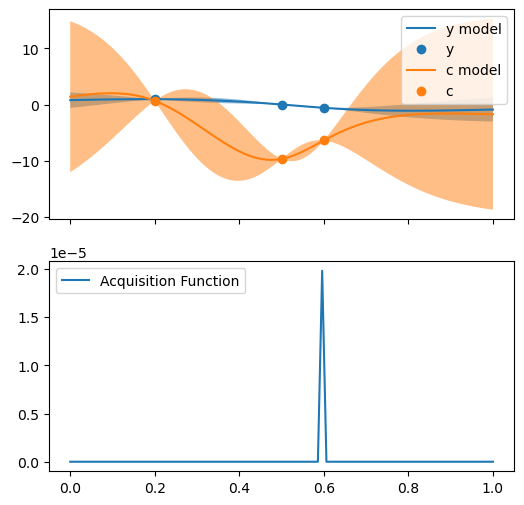

In [7]:
# plot the generator model and acquisition function

biasing_factor = [1.0, 0.5, 0.1, 0.01,0.001]

for ele in biasing_factor:
    generator = UpperConfidenceBoundGenerator(
        deepcopy(vocs), UpperConfidenceBoundGenerator.default_options()
    )

    generator.options.acq.proximal_lengthscales = [ele]
    visualize_model(generator, data)


# Model with standard transforms and proximal biasing + modified ranges
- model with large input space and small output space
- Observe that numerical instabilities exist for plotting the posterior but not the
acquisition function since the acquisition function operates on the standardized model.

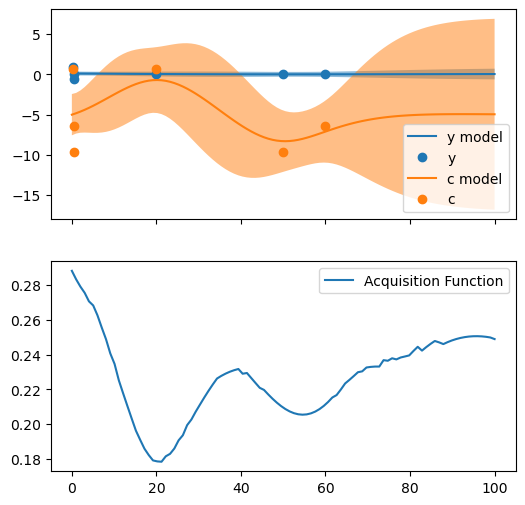

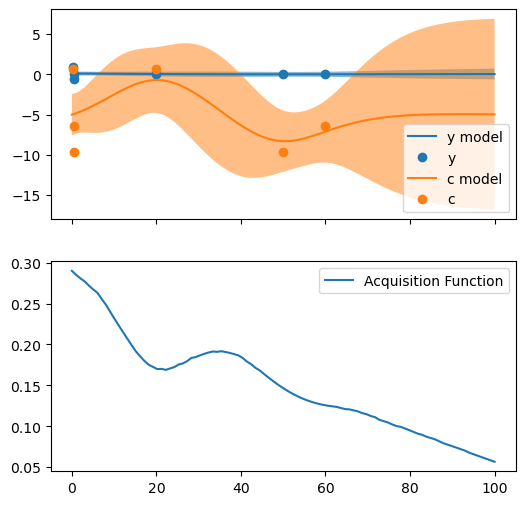

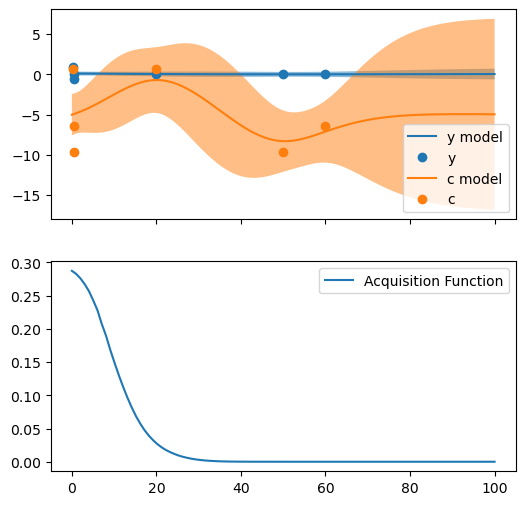

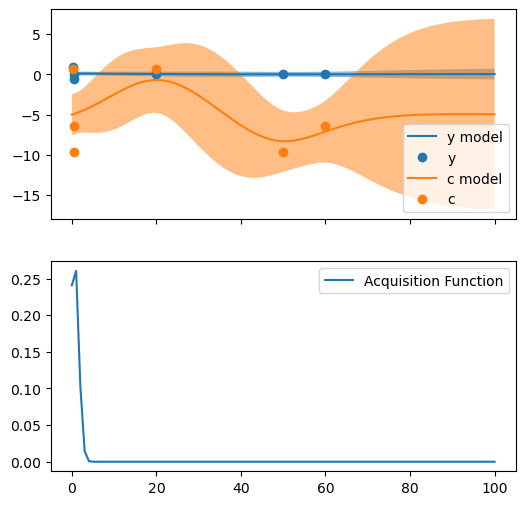

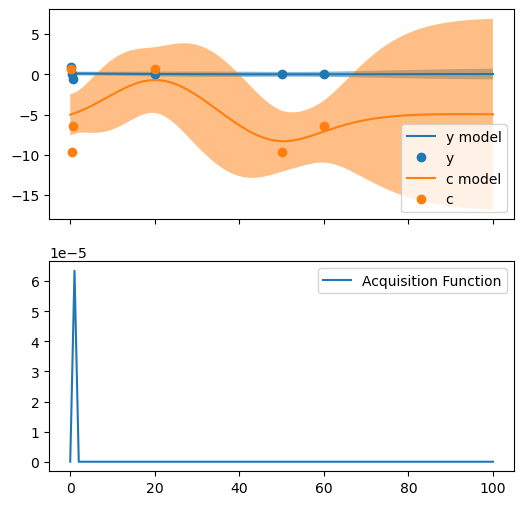

In [8]:
# plot the generator model and acquisition function
new_data = deepcopy(data)
input_scale = 1e2
output_scale = 1e-5

new_data['x'] = new_data["x"] * input_scale
new_data["y"] = new_data["y"] * output_scale

new_vocs = deepcopy(vocs)
new_vocs.variables["x"] = [0.0, input_scale]

biasing_factor = [1.0, 0.5, 0.1, 0.01,0.001]

new_test_x = test_x*input_scale

for ele in biasing_factor:
    generator = UpperConfidenceBoundGenerator(deepcopy(new_vocs), UpperConfidenceBoundGenerator.default_options())
    generator.add_data(new_data)

    generator.options.acq.proximal_lengthscales = [ele]

    visualize_model(generator, data)
